## illustrating how spatial averaging and optimization can create non-signal-related improvements in rmse

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [69]:
rows = 128
cols = 128

# create phony S1 signal, random values from a normal distribution
mean, std_dev = 3, 2  # mean snow depth of 3 m
s1_array = np.random.normal(mean, std_dev, (rows, cols))
#s1_array = np.random.rand(rows, cols)

# Create a phony lidar snow depth map with random values drawn from a different normal distribution
mean, std_dev = 1.5, 1  # mean snow depth of 3 m
lidar_array = np.random.normal(mean, std_dev, (rows, cols))

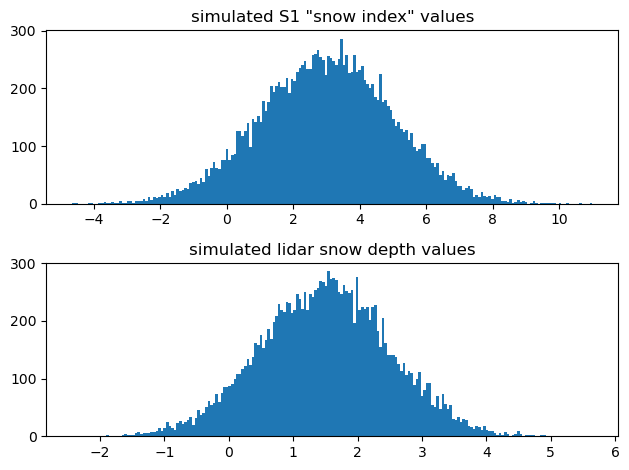

In [70]:
f, ax = plt.subplots(2, 1)
ax[0].hist(s1_array.ravel(), bins=200);
ax[0].set_title('simulated S1 "snow index" values')
ax[1].hist(lidar_array.ravel(), bins=200);
ax[1].set_title('simulated lidar snow depth values')
f.tight_layout()

In [71]:
# find optimal c value
c_optimal = lidar_array.mean()/s1_array.mean()
np.abs(lidar_array - s1_array).mean()

# set a range of possible c parameters
c_array = np.linspace(c_optimal-0.3, c_optimal+0.3, 20)
print(f'optimal c: {c_optimal}')

optimal c: 0.5008893546051679


In [72]:
def rmse(y_true, y_pred):
    squared_diff = (y_true - y_pred) ** 2
    mean_squared_diff = np.mean(squared_diff)
    rmse = np.sqrt(mean_squared_diff)
    return rmse

def mae(y_true, y_pred):
    absolute_diff = np.abs(y_true - y_pred)
    mae = np.mean(absolute_diff)
    return mae

def coarsen(input_array, factor):
    coarsened_array = input_array.reshape(int(input_array.shape[0]/factor), factor, int(input_array.shape[1]/factor), factor).mean(axis=(1, 3))
    return coarsened_array

# create rmse list for a range of coarsened arrays
def coarsened_rmses(c, s1_array, lidar_array, coarsening_factors=[2, 4, 8, 16]):
    s1_array_scaled = s1_array*c
    s1_list = []
    lidar_list = []
    for factor in coarsening_factors:
        s1_list.append(coarsen(s1_array_scaled, factor))
        lidar_list.append(coarsen(lidar_array, factor))

    rmse_list = []
    for i in range(len(coarsening_factors)):
        rmse_list.append(rmse(lidar_list[i], s1_list[i]))

    return s1_list, lidar_list, rmse_list

# create mae list for a range of coarsened arrays
def coarsened_maes(c, s1_array, lidar_array, coarsening_factors=[2, 4, 8, 16]):
    s1_array_scaled = s1_array*c
    s1_list = []
    lidar_list = []
    for factor in coarsening_factors:
        s1_list.append(coarsen(s1_array_scaled, factor))
        lidar_list.append(coarsen(lidar_array, factor))

    mae_list = []
    for i in range(len(coarsening_factors)):
        mae_list.append(mae(lidar_list[i], s1_list[i]))

    return s1_list, lidar_list, mae_list

In [73]:
coarsening_factors=[2, 4, 8, 16]

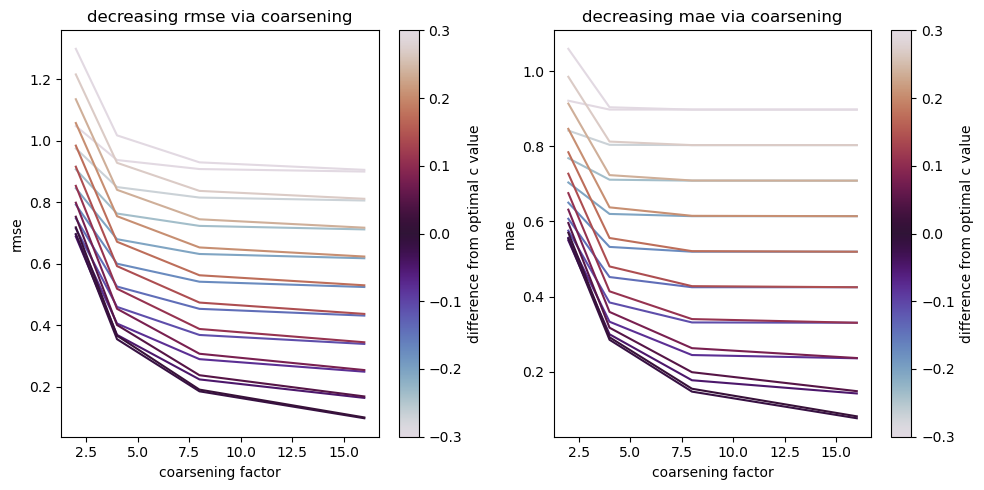

In [74]:
cmap = plt.get_cmap('twilight')
norm = plt.Normalize(min(c_array)-c_optimal, max(c_array)-c_optimal)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

f, ax = plt.subplots(1, 2, figsize=(10, 5))
for c in c_array:
    color = cmap(norm(c-c_optimal))
    ax[0].plot(coarsening_factors, coarsened_rmses(c, s1_array, lidar_array)[2], color=color)
    ax[1].plot(coarsening_factors, coarsened_maes(c, s1_array, lidar_array)[2], color=color)
cbar = plt.colorbar(sm, ax=ax[0], label='difference from optimal c value')
cbar = plt.colorbar(sm, ax=ax[1], label='difference from optimal c value')
ax[0].set_title('decreasing rmse via coarsening')
ax[0].set_xlabel('coarsening factor')
ax[0].set_ylabel('rmse')
ax[1].set_title('decreasing mae via coarsening')
ax[1].set_xlabel('coarsening factor')
ax[1].set_ylabel('mae')
f.tight_layout()

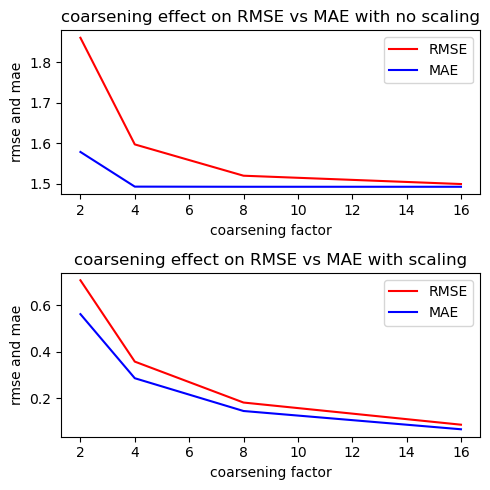

In [82]:
f, ax = plt.subplots(2, 1, figsize=(5, 5))
ax[0].plot(coarsening_factors, coarsened_rmses(1, s1_array, lidar_array)[2], color='r', label = 'RMSE')
ax[0].plot(coarsening_factors, coarsened_maes(1, s1_array, lidar_array)[2], color='b', label = 'MAE')
ax[0].set_title('coarsening effect on RMSE vs MAE with no scaling')
ax[0].set_xlabel('coarsening factor')
ax[0].set_ylabel('rmse and mae')
ax[0].legend()

ax[1].plot(coarsening_factors, coarsened_rmses(c_optimal, s1_array, lidar_array)[2], color='r', label = 'RMSE')
ax[1].plot(coarsening_factors, coarsened_maes(c_optimal, s1_array, lidar_array)[2], color='b', label = 'MAE')
ax[1].set_title('coarsening effect on RMSE vs MAE with scaling')
ax[1].set_xlabel('coarsening factor')
ax[1].set_ylabel('rmse and mae')
ax[1].legend()
f.tight_layout()

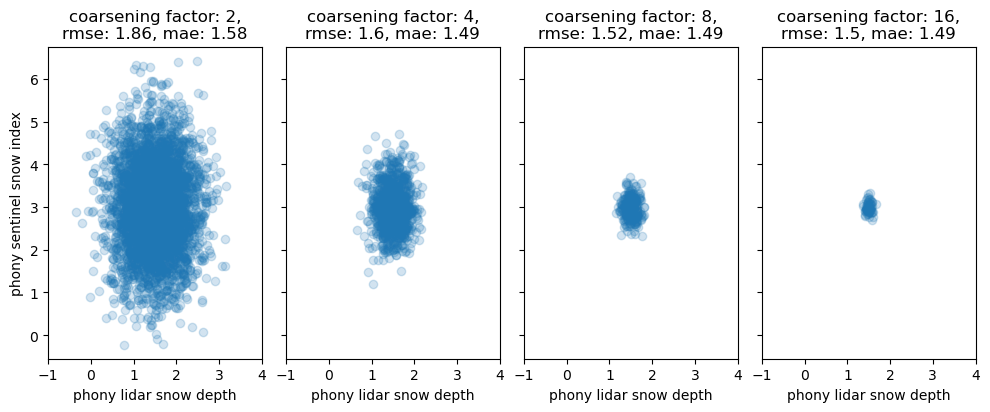

In [84]:
f, ax = plt.subplots(1, 4, figsize=(10, 5), sharex=True, sharey=True)
s1_list_noscale, lidar_list, rmse_list = coarsened_rmses(1, s1_array, lidar_array)
s1_list_noscale, lidar_list, mae_list = coarsened_maes(1, s1_array, lidar_array)
for i, factor in enumerate(coarsening_factors):
    ax[i].scatter(lidar_list[i].ravel(), s1_list_noscale[i].ravel(), alpha=0.2)
    ax[i].set_aspect('equal')
    ax[i].set_xlim(-1, 4)
    ax[i].set_title(f'coarsening factor: {factor},\nrmse: {round(rmse_list[i], 2)}, mae: {round(mae_list[i], 2)}')
    ax[i].set_xlabel('phony lidar snow depth')
ax[0].set_ylabel('phony sentinel snow index')
f.tight_layout()

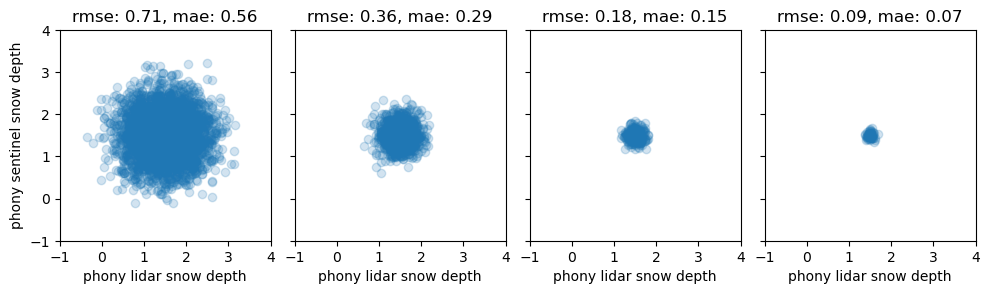

In [80]:
f, ax = plt.subplots(1, 4, figsize=(10, 5), sharex=True, sharey=True)
s1_list_scaled, lidar_list, rmse_list = coarsened_rmses(c_optimal, s1_array, lidar_array)
s1_list_scaled, lidar_list, mae_list = coarsened_maes(c_optimal, s1_array, lidar_array)
for i, factor in enumerate(coarsening_factors):
    ax[i].scatter(lidar_list[i].ravel(), s1_list_scaled[i].ravel(), alpha=0.2)
    ax[i].set_aspect('equal')
    ax[i].set_xlim(-1, 4)
    ax[i].set_ylim(-1, 4)
    ax[i].set_title(f'rmse: {round(rmse_list[i], 2)}, mae: {round(mae_list[i], 2)}')
    ax[i].set_xlabel('phony lidar snow depth')
ax[0].set_ylabel('phony sentinel snow depth')
f.tight_layout()